In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import numpy as np
from sklearn.linear_model import LinearRegression

### Загрузка фактического потребления энергии в ОЭС Урала

In [2]:
energy = pd.read_csv("energy_ural.csv", delimiter=";")
energy.iloc[-10:].head(3)

,INTERVAL,M_DATE,PRICE_ZONE_ID,POWER_SYS_ID,E_USE_FACT,E_USE_PLAN,GEN_FACT,GEN_PLAN
113150,14,27.11.2020 0:00:00,1.0,630000.0,32323.0,32112.0,32469.0,32451.0
113151,15,27.11.2020 0:00:00,1.0,630000.0,32651.0,32630.0,32206.0,32086.0
113152,16,27.11.2020 0:00:00,1.0,630000.0,32431.0,32491.0,32360.0,32227.0


### Фильтрация доступных дат и форматирование типов данных

In [3]:
energy=energy[energy.PRICE_ZONE_ID==1]
energy['M_DATE'] = energy.M_DATE.apply(lambda x: datetime.strptime(x, '%d.%m.%Y %H:%M:%S'))
energy['time'] = energy[['M_DATE', 'INTERVAL']].apply(lambda x:  x[0] + + timedelta(hours=x[1]), axis=1)
energy['Y']=energy.E_USE_FACT
energy=energy[['Y', 'time']]
energy=energy.sort_values('time')

### Получаем целевую переменную в поле Y на 10 лет со значениями кадый час

In [4]:
print("objects count " + str(len(energy)))
energy.head(3)

objects count 91489


,Y,time
21671,22446.0,2010-06-21 23:00:00
21672,22079.0,2010-06-22 00:00:00
21673,21851.0,2010-06-22 01:00:00


### Ищем средние значения целевой переменной за сутки, так как признаки которые мы будем использовать доступны только с таким интервалом

In [5]:
per = energy.time.dt.to_period("D")
energy_days = energy.Y.groupby(per).sum().reset_index()
energy_days['dayofyear']=energy_days.time.dt.dayofyear
energy_days=energy_days.iloc[1:]
energy_days=energy_days[energy_days.Y>200000]

In [6]:
energy_days.head(3)

,time,Y,dayofyear
1,2010-06-22,571372.0,173
2,2010-06-23,571281.0,174
3,2010-06-24,573894.0,175


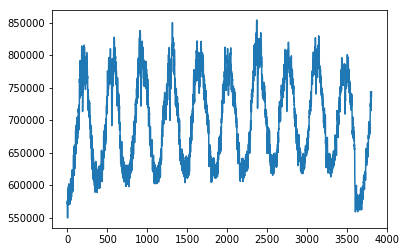

In [7]:
plt.plot(range(len(energy_days)), energy_days.Y)

## На графике видна сезонность ОЗП. То есть 1 год - один период
### Мы проверили несколько гипотез причин сезонности и выявили основные 

In [8]:
dataset = energy_days

### Температура 
Мы собрали информацию о средней температуре уральськой ОЭС

In [9]:
temp = pd.read_csv("tepm_ural.csv")
temp.iloc[::100].head(3)

,date,temp
0,07-01-2011,-20.0
100,01-06-2017,10.9
200,02-01-2013,-17.6


### Джойним температуру к целевой переменной

In [10]:
temp=temp.drop_duplicates()
temp['date']=temp['date'].\
apply(lambda x: datetime.strptime(x, '%d-%m-%Y').strftime('%Y-%m-%d'))
dataset['time_str'] = dataset.time.apply(lambda x: str(x))
dataset=pd.merge(dataset, temp, left_on='time_str', right_on='date', how='left')


In [11]:
dataset.iloc[::100].head(3)

,time,Y,dayofyear,time_str,date,temp
0,2010-06-22,571372.0,173,2010-06-22,2010-06-22,16.6
100,2010-09-30,653519.0,273,2010-09-30,2010-09-30,12.3
200,2011-01-08,756302.0,8,2011-01-08,2011-01-08,-20.0


### Продолжительность светового дня
мы собрали информацию о восходе и закате солнца за год в Перми

In [12]:
sun_time = pd.read_csv("time_perm.csv")
sun_time.head(3)

,day_n,start_hours,start_minutes,end_hours,end_minutes
0,1,10,0,16,36
1,2,10,0,16,37
2,3,9,59,16,38


### Джойним время темных часов к датасету

In [13]:
sun_time["night_minutes"] = 24*60-(sun_time.end_hours*60+sun_time.end_minutes-sun_time.start_hours*60-sun_time.start_minutes)
dataset = pd.merge(dataset, sun_time, left_on=['dayofyear'], right_on='day_n')
dataset=dataset.sort_values('time')
# dataset=dataset[['time', 'Y', 'dayofyear', 'temp', 'night_minutes']]
dataset.head(3)
dataset=dataset.sort_values('time')

### создадим функцию для обучения линейной регрессии

In [14]:
def train_lin_reg(features, valid_days = 365):
    if valid_days == 0:
        train_dataset=dataset
    else:
        train_dataset=dataset.iloc[:-valid_days]
    X = train_dataset[features].values
    y = train_dataset.Y.values
    reg = LinearRegression().fit(X, y)
    print('quality ' +  str(reg.score(X, y)))
    W = reg.coef_
    bias = reg.intercept_
    return W, bias

    

In [15]:
features = ['night_minutes','temp']
W, bias = train_lin_reg(features, valid_days = 365)

quality 0.920417990045


### посмотрим на предсказания в на валидации
голубой - фактические значения, 
ораньжевый- предсказанные

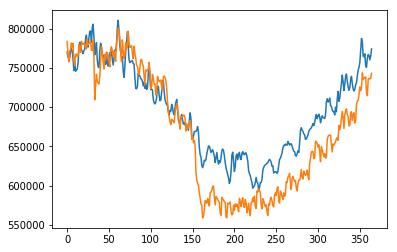

In [16]:
X = dataset.iloc[-365:][features].values
Y = dataset.iloc[-365:].Y
predict = np.sum(X*W, axis = 1)+bias
plt.plot(range(len(X)), predict)
plt.plot(range(len(X)), Y)

### посмотрим на предсказания на всех данных
голубой - фактические значения, 
ораньжевый- предсказанные

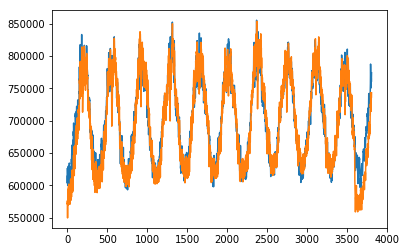

In [17]:
X = dataset[features].values
Y = dataset.Y
predict = np.sum(X*W, axis = 1)+bias
plt.plot(range(len(X)), predict)
plt.plot(range(len(X)), Y)

### посмотрим ошибку предсказаний
Можно заметить что сезонность была сглажена, в 2020 году видна ошибка из за covid и видны выбросы периодичные

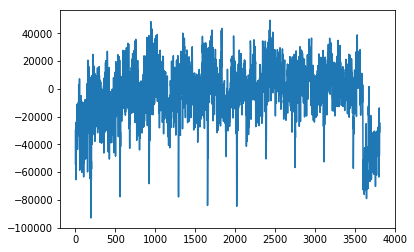

In [18]:
error = Y-predict
plt.plot(range(len(X)), error)

### посмотрим что за выбросы

In [19]:
max_ids = np.argsort(-np.abs(error.values))[:5]
dataset.iloc[max_ids]

,time,Y,dayofyear,time_str,date,temp,day_n,start_hours,start_minutes,end_hours,end_minutes,night_minutes
2089,2011-01-01,713187.0,1,2011-01-01,2011-01-01,-19.00,1,10,0,16,36,1044
2094,2016-01-01,738251.0,1,2016-01-01,2016-01-01,-23.89,1,10,0,16,36,1044
2093,2015-01-01,741194.0,1,2015-01-01,2015-01-01,-24.57,1,10,0,16,36,1044
3746,2020-06-14,563528.0,166,2020-06-14,2020-06-14,11.68,166,4,11,22,19,352
2112,2014-01-03,748953.0,3,2014-01-03,2014-01-03,-25.12,3,9,59,16,38,1041


### 01-01, 06-14 Это новый год и праздники + выходные

### Давайте соберем выходные за 10 лет...  
NY - новый год

not_weekend - рабочие субботы и воскресения

holliday - праздничный день

In [20]:
hollydays=pd.read_csv("hollydays.csv")
need_dates = set(dataset.time_str.values)
hollydays=hollydays[hollydays.date.apply(lambda x: x in need_dates)]
hollydays=hollydays.drop_duplicates()
hollydays.head()

,date,NY,not_weekend,holliday
10,2011-01-01,1,0,0
11,2011-01-02,1,0,0
12,2011-01-03,1,0,0
13,2011-01-04,1,0,0
14,2011-01-05,1,0,0


### Определяем выходные дни и джойним праздники

In [21]:
dataset=pd.merge(dataset, hollydays, left_on='time_str', right_on='date', how='left')
dataset=dataset.fillna(0)
dataset['sunday'] = (dataset.time.dt.dayofweek==6).astype('int')
dataset['saturday'] = (dataset.time.dt.dayofweek==5).astype('int')
dataset.loc[dataset.not_weekend==1, ['sunday', 'saturday']]=0

### устанавливаем параметр covid=1 с 31 марта 2020 года

In [22]:
march31=3740+24
november30=4022

dataset["day_n"] = ((dataset.time.dt.year-2010)*365)+dataset.time.dt.dayofyear
covid = pd.DataFrame({"day_n":np.arange(march31, november30), "covid_cases": [1 for i in np.arange(0,november30-march31)]})
dataset=pd.merge(dataset, covid, left_on='day_n', right_on='day_n', how='left').fillna(0)


### учим модель с новыми фичами

In [23]:
features = ['night_minutes','temp','NY','holliday','sunday', 'saturday', "covid_cases"]
W, bias = train_lin_reg(features, valid_days = 0)

quality 0.951033489438


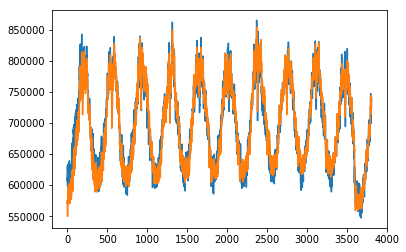

In [24]:
X = dataset[features].values
Y = dataset.Y
predict_new = np.sum(X*W, axis = 1)+bias
plt.plot(range(len(X)), predict_new)
plt.plot(range(len(X)), Y)

### синяя - старая ошибка
### ораньжевая - новая ошибка (с новыми фичами)

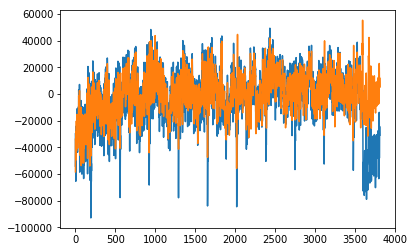

In [25]:
error_new = Y-predict_new
plt.plot(range(len(X)), error)
plt.plot(range(len(X)), error_new)

### видно что ошибка значительно уменьшилась, особенно в праздничные дни и во время ковида

### Данные для инференса модели

In [26]:
dataset['date']=dataset.time
features.append('date')
features.append('Y')
dataset[features].to_csv('dataset.csv')

In [27]:
print(W, bias)

(array([    89.88676302,  -3456.49612693, -45900.69437087, -19068.73288381,
       -20022.6006436 , -14505.60244218, -44930.11932161]), 655854.84556238924)


### Попробуем посмотреть на экономические показатели

In [28]:
economical = pd.read_csv("economical.csv", delimiter=",")
dataset['month'] = dataset.time.dt.year*12+dataset.time.dt.month
dataset=pd.merge(dataset, economical, left_on='month', right_on='month', how='left').fillna(0)


In [29]:
features = ['night_minutes','temp','NY','holliday','sunday', 'saturday', "covid_cases"]
W, bias = train_lin_reg(features, valid_days = 0)
print("---------------")
for f in economical.columns[1:]:
    features = ['night_minutes','temp','NY','holliday','sunday', 'saturday', "covid_cases", f]
    print("use " + f)
    W, bias = train_lin_reg(features, valid_days = 0)
    print("weight " + str(W[-1]))
    print("---------------")



quality 0.951033489438
---------------
use food_gen
quality 0.95134379651
weight -139.067612768
---------------
use investment
quality 0.951405307654
weight -0.027392659043
---------------
use salary
quality 0.952691977293
weight 0.56537691844
---------------
use house_built
quality 0.952157411579
weight -9.58110138604
---------------
use sale
quality 0.955054961894
weight 0.620049462192
---------------
use salary_arrears
quality 0.959909414233
weight -0.150197707475
---------------
use agricultural_industry
quality 0.951752560259
weight 34.8247024881
---------------
use food_price
quality 0.955660937809
weight 7.65047104013
---------------


### можно заметить что хорошо коррелируют следущие экономические показатели
salary_arrears (задолжности по зп) с отрицательным весом

sale (розничные продажи) с положительным весои

food_price (цена мин корзины) с положительным весои

In [30]:
features = ['night_minutes','temp','NY','holliday','sunday', 'saturday', "covid_cases"]
features.extend(economical.columns[1:])
W, bias = train_lin_reg(features, valid_days = 0)


quality 0.965225942778


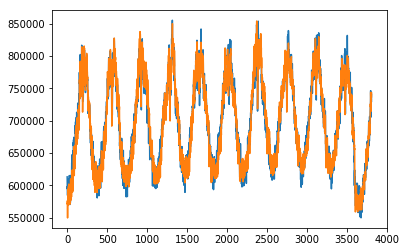

In [31]:
X = dataset[features].values
Y = dataset.Y
predict_new2 = np.sum(X*W, axis = 1)+bias
plt.plot(range(len(X)), predict_new2)
plt.plot(range(len(X)), Y)

### смотрим ошибку модели с учетом экономических показателей
синяя - без эконом показателей
ораньжевая - с эконом показателями

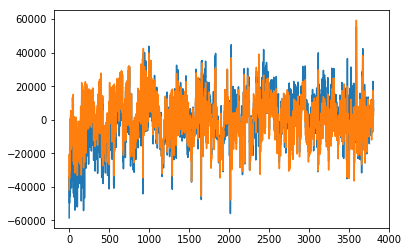

In [32]:
error_new2 = Y-predict_new2
# plt.plot(range(len(X)), error)
plt.plot(range(len(X)), error_new)
plt.plot(range(len(X)), error_new2)